# Vit from scratch

In [1]:
# libraries and modules
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

In [133]:
# transforming images using Imagenet mean & std
# imagenet_mean = [0.485, 0.456, 0.406]
# imagenet_std = [0.229, 0.224, 0.225]
img_size = 32


transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

## Datasets and Dataloading

In [135]:
# loading dataset
from torchvision.datasets import MNIST

train_dataset = MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

val_dataset = MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

# # If you need the test set:
# test_dataset = Flowers102(
#     root="./data",
#     split="test",
#     download=True,
#     transform=transform
# )

In [136]:
# variables
num_classes = len(train_dataset.classes)
batch_size = 128
patch_size = 8
num_patches = (img_size // patch_size) ** 2
embedding_dim = 64
attention_heads = 4
transformer_blocks = 4
mlp_hidden_dim = embedding_dim * 2
learning_rate = 1e-3
epochs = 5

sample_image, label = train_dataset[0]
channels = sample_image.shape[0]


In [137]:
print(f"Sample image shape: {sample_image.size()}")
print(f"Number of channels : {channels}")
print(f"Number of classes: {num_classes}")
print(f"Number of patches: {num_patches}")

Sample image shape: torch.Size([1, 32, 32])
Number of channels : 1
Number of classes: 10
Number of patches: 16


In [138]:
#Dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Model Layer and Architecture

### 1 - Patch Embedding

In [139]:
class PatchEmbedding(nn.Module):
    def __init__(self):
      super().__init__()
      self.patch_embed = nn.Conv2d(channels,embedding_dim,kernel_size=patch_size,stride=patch_size)

    def forward(self,x):
      x = self.patch_embed(x)
      x = x.flatten(2).transpose(1,2) # (Batch_size, Patch_size, embedding_dim)
      return x

### 2 - Transformer encoder

In [140]:
class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    # layers
    self.norm1 = nn.LayerNorm(embedding_dim)
    self.norm2 = nn.LayerNorm(embedding_dim)
    self.multihead_attention = nn.MultiheadAttention(embedding_dim, num_heads=attention_heads, batch_first=True)
    self.mlp = nn.Sequential(
        nn.Linear(embedding_dim, mlp_hidden_dim),
        nn.GELU(),
        nn.Linear(mlp_hidden_dim, embedding_dim)
    )

  def forward(self,x):
    residual1 = x
    x = self.norm1(x)
    x = self.multihead_attention(x,x,x)[0]
    x = x + residual1

    residual2 = x
    x = self.norm2(x)
    x = self.mlp(x)

    return x + residual2

### 3 - MLP head

In [141]:
class MLPHead(nn.Module):
  def __init__(self):
    super().__init__()
    self.norm = nn.LayerNorm(embedding_dim)
    self.mlp_head = nn.Linear(embedding_dim, num_classes)

  def forward(self,x):
    x= self.norm(x)
    x = self.mlp_head(x)
    return x

### 4 - Full Vit model

In [142]:
class VisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding = PatchEmbedding()
    self.cls_token = nn.Parameter(torch.randn(1,1,embedding_dim))
    self.pos_embedding = nn.Parameter(torch.randn(1,num_patches+1,embedding_dim))
    self.transformer_blocks = nn.Sequential(*[TransformerEncoder() for _ in range(transformer_blocks)])
    self.mlp_head = MLPHead()

  def forward(self,x):
    x = self.patch_embedding(x)
    class_tokens = self.cls_token.expand(x.shape[0],-1,-1)
    x = torch.cat((class_tokens,x), dim=1)
    x = x + self.pos_embedding
    x = self.transformer_blocks(x)
    x = x[:,0]
    x = self.mlp_head(x)
    return x

## training

In [143]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [144]:
# initializing model
model = VisionTransformer().to(device)

# optimizer and other stuff
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [145]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    print(f"\nEpoch {epoch+1}/{epochs}")

    # Use tqdm on the dataloader for batch progress
    train_bar = tqdm(train_loader, desc="Training")

    for batch_idx, (images, labels) in enumerate(train_bar):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate metrics
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        total_correct += torch.sum(preds == labels).item()
        total_samples += labels.size(0)

        # Update progress bar with current batch metrics
        batch_accuracy = torch.sum(preds == labels).item() / labels.size(0)
        train_bar.set_postfix(
            loss=f"{loss.item():.4f}",
            acc=f"{batch_accuracy*100:.2f}%"
        )

    # Calculate epoch metrics
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = (total_correct / total_samples) * 100

    print(f"Epoch {epoch+1} - Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.2f}")

    # Optional: Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_samples = 0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc="Validation")
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += torch.sum(preds == labels).item()
            val_samples += labels.size(0)

            val_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_val_loss = val_loss / len(val_loader)
    avg_val_accuracy = (val_correct / val_samples) * 100

    print(f"Epoch {epoch+1} - Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.2f}")


Epoch 1/5


Training: 100%|██████████| 469/469 [00:16<00:00, 28.43it/s, acc=96.88%, loss=0.1527]


Epoch 1 - Train Loss: 0.4900, Train Accuracy: 84.37


Validation: 100%|██████████| 79/79 [00:01<00:00, 44.09it/s, loss=0.2471]


Epoch 1 - Val Loss: 0.1799, Val Accuracy: 94.37

Epoch 2/5


Training: 100%|██████████| 469/469 [00:15<00:00, 29.57it/s, acc=98.96%, loss=0.1560]


Epoch 2 - Train Loss: 0.1522, Train Accuracy: 95.32


Validation: 100%|██████████| 79/79 [00:01<00:00, 44.37it/s, loss=0.0416]


Epoch 2 - Val Loss: 0.1322, Val Accuracy: 95.69

Epoch 3/5


Training: 100%|██████████| 469/469 [00:16<00:00, 28.04it/s, acc=97.92%, loss=0.1636]


Epoch 3 - Train Loss: 0.1060, Train Accuracy: 96.72


Validation: 100%|██████████| 79/79 [00:01<00:00, 44.13it/s, loss=0.1472]


Epoch 3 - Val Loss: 0.1215, Val Accuracy: 95.97

Epoch 4/5


Training: 100%|██████████| 469/469 [00:15<00:00, 29.60it/s, acc=97.92%, loss=0.1445]


Epoch 4 - Train Loss: 0.0807, Train Accuracy: 97.47


Validation: 100%|██████████| 79/79 [00:01<00:00, 44.64it/s, loss=0.0925]


Epoch 4 - Val Loss: 0.0959, Val Accuracy: 96.90

Epoch 5/5


Training: 100%|██████████| 469/469 [00:16<00:00, 28.27it/s, acc=97.92%, loss=0.1481]


Epoch 5 - Train Loss: 0.0689, Train Accuracy: 97.86


Validation: 100%|██████████| 79/79 [00:01<00:00, 43.86it/s, loss=0.0915]

Epoch 5 - Val Loss: 0.0984, Val Accuracy: 97.03


## Plot

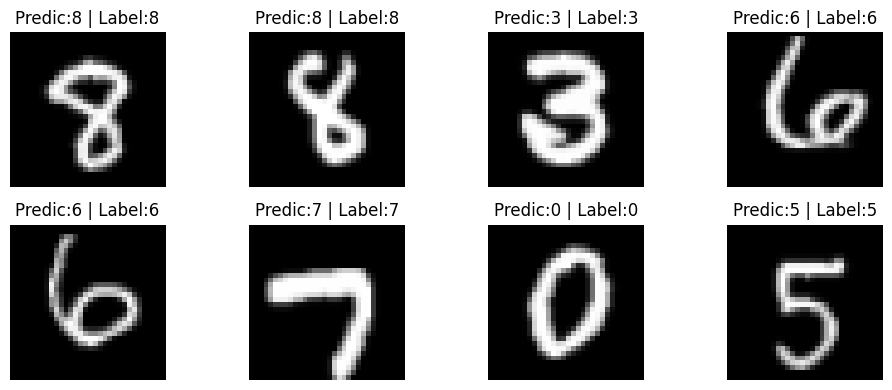

In [151]:
model.eval()

images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# move to cpu for plotting
images = images.cpu()
preds = preds.cpu()
labels = labels.cpu()

plt.figure(figsize=(10, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    img = images[i].squeeze(0)
    plt.imshow(img, cmap='gray')
    plt.title(f"Predic:{preds[i].item()} | Label:{labels[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()
